In [1]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F

from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import KFold
import wandb

from data_loader import load_data, get_balanced_data, normalize_features, DATA_FEATURE_NAMES_LIST, concat_group_data

USE_CONCAT_CTS = True

if USE_CONCAT_CTS:
    CTS = ['L23_IT_CTX_Glut', 'L6_CT_CTX_Glut', 'L5_ET_CTX_Glut','L6_IT_CTX_Glut'] #
    CT = ','.join(CTS)
    X_balanced, y_balanced, gene_list = concat_group_data(CT)
else:
    CT = 'CA1-ProS_Glut'
    data = load_data(ct=CT)
    X_balanced, y_balanced, gene_list = get_balanced_data(data)
assert len(y_balanced) == len(gene_list)
CTS = ['L23_IT_CTX_Glut', 'L6_CT_CTX_Glut', 'L5_ET_CTX_Glut','L6_IT_CTX_Glut'] #
CT = ','.join(CTS)
X_balanced, y_balanced, gene_list = concat_group_data(CT)
assert len(y_balanced) == len(gene_list)
FEATURE_MODALITIES = DATA_FEATURE_NAMES_LIST

for k, v in X_balanced.items():
    print(k, len(v))
# y_balanced = y_balanced[:, 2]
# print('zero:', (y_balanced == 0).sum(), 'non-zero:', (y_balanced != 0).sum())


Processed dmr data
Processed mCG genebody data
Processed mCH genebody data
Processed atac data
Processed abc dmr data
Processed abc peak data
Processed hic loop data
Preparing data
zero: 7789, up: 203,down: 1361
Getting balanced data

Processed dmr data
Processed mCH genebody data
Processed mCG genebody data
Processed atac data
Processed abc dmr data
Processed abc peak data
Processed hic loop data
Preparing data
zero: 7885, up: 141,down: 1330
Getting balanced data

Processed dmr data
Processed mCG genebody data
Processed mCH genebody data
Processed atac data
Processed abc dmr data
Processed abc peak data
Processed hic loop data
Preparing data
zero: 8692, up: 78,down: 413
Getting balanced data

Processed dmr data
Processed mCH genebody data
Processed atac data
Processed mCG genebody data
Processed abc dmr data
Processed abc peak data
Processed hic loop data
Preparing data
zero: 9063, up: 32,down: 158
Getting balanced data

Processed dmr data
Processed mCH genebody data
Processed mCG ge

In [2]:
assert len(y_balanced) == len(gene_list)


In [3]:
# check how many  0 , -1 and 1 in y_balanced
print('y_balanced 0:', np.sum(y_balanced == 0))
print('y_balanced -1:', np.sum(y_balanced == -1))
print('y_balanced 1:', np.sum(y_balanced == 1))


y_balanced 0: 454
y_balanced -1: 454
y_balanced 1: 454


In [4]:
import wandb


In [19]:
import os
# 63%
HIDDEN_DIM = 64
NUM_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.1
LR = 3e-3
OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
NUM_EPOCHS = 20
BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 4
# NUM_HEADS = 8
# DROPOUT = 0.0
# LR = 0.03
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 20
# BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 1
# NUM_HEADS = 1
# DROPOUT = 0.3
# LR = 1e-4
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 200
# BATCH_SIZE = 16


class MultiModalityTransformerModel(nn.Module):
    def __init__(self, modality_input_dims, hidden_dim, output_dim, num_layers=2, num_heads=1, dropout=0.1):
        super(MultiModalityTransformerModel, self).__init__()
        self.cls_embeddings = nn.ParameterDict({modality: nn.Parameter(torch.randn(1, 1, hidden_dim)) for modality in FEATURE_MODALITIES})
        self.modality_embeddings = nn.ModuleDict({modality: nn.Linear(modality_input_dims[modality], hidden_dim) for modality in FEATURE_MODALITIES})

        # TODO: may need to use tanh in attention instead of softmax
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim*4, dropout=dropout, batch_first=True, norm_first=True)
        self.modality_transformers = nn.ModuleDict({modality: nn.TransformerEncoder(encoder_layers, num_layers) for modality in FEATURE_MODALITIES})

        # Add one dimension for the sequence length
        self.batch_norms = nn.ModuleDict({modality: nn.BatchNorm1d(hidden_dim + 1) for modality in FEATURE_MODALITIES})
        
        # Use self-attention mechanism to combine the outputs of the four heads
        self.query = nn.Parameter(torch.randn(1, hidden_dim))
        self.key_layer = nn.Linear(hidden_dim + 1, hidden_dim)
        self.value_layer = nn.Linear(hidden_dim + 1, hidden_dim)
        self.attn_output_norm = nn.BatchNorm1d(hidden_dim)
        self.attn_output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_dim),
            )
        self.classifier = nn.Linear(hidden_dim, output_dim)
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Parameter):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)


        

    def forward(self, x_dict, mask_dict, get_attn_weights=False):
        # Add cls embedding, so that we can take the first output as the representation of the sequence
        modality_cls_embeddings = {modality: self.cls_embeddings[modality].repeat(x_dict[modality].size(0), 1, 1) for modality in FEATURE_MODALITIES}


        modality_embeddings = {modality: self.modality_embeddings[modality](x_dict[modality]) for modality in FEATURE_MODALITIES}

        modality_embeddings = {modality: torch.cat((modality_cls_embeddings[modality], modality_embeddings[modality]), dim=1) for modality in FEATURE_MODALITIES}

        modality_masks = {modality: torch.cat((torch.ones(mask_dict[modality].size(0), 1), mask_dict[modality]), dim=1) for modality in FEATURE_MODALITIES}

        modality_outputs = {modality: self.modality_transformers[modality](modality_embeddings[modality], src_key_padding_mask=~modality_masks[modality].bool()) for modality in FEATURE_MODALITIES}

        seq_lengths = {modality: torch.log(1 + mask_dict[modality].sum(dim=1).unsqueeze(-1)) for modality in FEATURE_MODALITIES}
        # Pooling, we should not use average pooling since the sequence length is also important
        modality_outputs = {modality: torch.cat((modality_outputs[modality][:, 0, :], seq_lengths[modality]), dim=1) for modality in FEATURE_MODALITIES}

        modality_outputs = {modality: self.batch_norms[modality](modality_outputs[modality]) for modality in FEATURE_MODALITIES}

        # Combine the output of four heads into a sequence
        combined_x = torch.stack([modality_outputs[modality] for modality in FEATURE_MODALITIES], dim=1) # (batch_size, M, hidden_dim)

        # self-attention
        keys = self.key_layer(combined_x) # [N, M, d]
        values = self.value_layer(combined_x) # [N, M, d]
        query = self.query.expand(combined_x.size(0), -1).unsqueeze(-1)  # [N, d, 1]
        attn_scores = torch.matmul(keys, query).squeeze(-1)  # [N, M]
        attn_weights = F.softmax(attn_scores, dim=-1)  # [N, M]

        combined_x = torch.sum(values * attn_weights.unsqueeze(-1), dim=1) # [N, d]
        combined_x = self.attn_output_norm(combined_x)
        residual = combined_x
        combined_x = self.attn_output_layer(combined_x) 
        combined_x += residual
    
        output = self.classifier(combined_x)
        if get_attn_weights:
            return output, attn_weights
        else:
            return output

class CombinedGeneDataset(Dataset):
    def __init__(self, x_dict, labels):
        self.x_dict = x_dict
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        x_dict = {modality: torch.FloatTensor(self.x_dict[modality][idx]) for modality in FEATURE_MODALITIES} # [M, seq_len, D]
        label = torch.LongTensor([self.labels[idx].item() + 1])  # Add 1 to shift labels to 0, 1, 2
        return x_dict, label

def combined_collate_fn(batch):
    batch.sort(key=lambda x: len(x[0][FEATURE_MODALITIES[0]]), reverse=True)
    x_list, labels = zip(*batch) # x_dict: {modality: [N, seq_len, D]}

    # Permute the dimensions of x_list to [M, N, seq_len, D]
    batched_x_dict = {modality: [x_list[i][modality] for i in range(len(x_list))] for modality in FEATURE_MODALITIES}

    modality_lengths = {modality: [len(seq) for seq in batched_x_dict[modality]] for modality in FEATURE_MODALITIES} # [N, M]
    modality_max_len = {modality: max(modality_lengths[modality]) for modality in FEATURE_MODALITIES} # [M]
    padded_x_dict = {modality: torch.zeros(len(batched_x_dict[modality]), modality_max_len[modality], batched_x_dict[modality][0].size(1)) for modality in FEATURE_MODALITIES} # [M, N, max_seq_len, D]
    padded_mask_dict = {modality: torch.zeros(len(batched_x_dict[modality]), modality_max_len[modality]) for modality in FEATURE_MODALITIES} # [M, N, max_seq_len]
    for modality, modality_seqs in batched_x_dict.items():
        for batch_idx, (seq, length) in enumerate(zip(modality_seqs, modality_lengths[modality])):
            padded_x_dict[modality][batch_idx, :length] = seq
            padded_mask_dict[modality][batch_idx, :length] = 1
    return padded_x_dict, padded_mask_dict, torch.cat(labels)

def train_combined_model(X_train_dict, y_train, X_test_dict, y_test, exp_name, fold_idx):
    #wandb.init(project='gene', group=exp_name, name=f'fold-{fold_idx}')
    modality_input_dims = {modality: len(X_train_dict[modality][0][0]) for modality in FEATURE_MODALITIES} 

    train_dataset = CombinedGeneDataset(X_train_dict, y_train)
    test_dataset = CombinedGeneDataset(X_test_dict, y_test)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=combined_collate_fn, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=combined_collate_fn)

    model = MultiModalityTransformerModel(modality_input_dims, HIDDEN_DIM, OUTPUT_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT)

    from sklearn.utils.class_weight import compute_class_weight

    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weights = torch.FloatTensor(class_weights)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    # optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    # lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-3)
    lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS, final_div_factor=10)

    # Create the OneCycleLR scheduler
    # lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, total_steps=NUM_EPOCHS,
    #                           pct_start=0.8, anneal_strategy='cos',
    #                           cycle_momentum=False, div_factor=5.0,
    #                           final_div_factor=10.0)

    def evaluate(model):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_list, mask_list, batch_y in test_loader:
                outputs = model(x_list, mask_list)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y.squeeze()).sum().item()
        return correct / total
    
    print(f'Initial Test Accuracy: {evaluate(model):.4f}')

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        for x_list, mask_list, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(x_list, mask_list)
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            total_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y.squeeze()).sum().item()
            train_total += batch_y.size(0)

        accuracy = evaluate(model)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_correct/train_total:.4f}, Test Accuracy: {accuracy:.4f}')

        wandb.log({'epoch': epoch, 'LR': optimizer.param_groups[0]['lr'], 'train_loss': total_loss/len(train_loader), 'train_accuracy': train_correct/train_total, 'test_accuracy': accuracy})

    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for x_list, mask_list, batch_y in test_loader:
            outputs = model(x_list, mask_list)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    final_accuracy = sum(np.array(all_predictions) == np.array(all_labels).squeeze()) / len(all_labels)
    print(f'Final Test Accuracy: {final_accuracy:.4f}')
    return final_accuracy, all_predictions, all_labels, model

In [20]:
import time
exp_name = f'multi-modality-{time.strftime("%Y%m%d-%H%M%S")}'
wandb.init(project='gene', group=exp_name, name=exp_name, settings=wandb.Settings(code_dir="."))

wandb.config.update({
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'num_heads': NUM_HEADS,
    'dropout': DROPOUT,
    'lr': LR,
    'output_dim': OUTPUT_DIM,
    'num_epochs': NUM_EPOCHS,
})


kf = KFold(n_splits=5, shuffle=True, random_state=25)
accuracies = []
k_fold_indices = []
for i, (train_index, test_index) in enumerate(kf.split(X_balanced[FEATURE_MODALITIES[0]])):
    k_fold_indices.append((train_index, test_index))
    X_train_dict = {modality: [X_balanced[modality][i] for i in train_index] for modality in FEATURE_MODALITIES}
    X_test_dict = {modality: [X_balanced[modality][i] for i in test_index] for modality in FEATURE_MODALITIES}
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]

    X_train_normalized_dict = {}
    X_test_normalized_dict = {}
    for modality in FEATURE_MODALITIES:
        X_train_normalized_dict[modality], X_test_normalized_dict[modality] = normalize_features(X_train_dict[modality], X_test_dict[modality])
    
    acc, preds, labels, model = train_combined_model(X_train_normalized_dict, y_train, X_test_normalized_dict, y_test, exp_name=exp_name, fold_idx=i)
    os.makedirs(f'ml_output/{CT}', exist_ok=True)
    torch.save(model.state_dict(), f'ml_output/{CT}/model_{i}.pth')
    accuracies.append(acc)


    # acc, preds, labels, model = train_combined_model(X_train_dmr_normalized, X_train_atac_normalized, X_train_hic_normalized, X_train_genebody_normalized, y_train,
    #                                           X_test_dmr_normalized, X_test_atac_normalized, X_test_hic_normalized, X_test_genebody_normalized, y_test, exp_name=exp_name, fold_idx=i)
    # break

# print(f'Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

/opt/conda/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Initial Test Accuracy: 0.3407
Epoch [1/20], Train Loss: 1.8469, Train Accuracy: 0.3520, Test Accuracy: 0.3407
Epoch [2/20], Train Loss: 1.5392, Train Accuracy: 0.3410, Test Accuracy: 0.3700
Epoch [3/20], Train Loss: 1.2974, Train Accuracy: 0.3640, Test Accuracy: 0.3370
Epoch [4/20], Train Loss: 1.2528, Train Accuracy: 0.3750, Test Accuracy: 0.3846
Epoch [5/20], Train Loss: 1.2237, Train Accuracy: 0.4118, Test Accuracy: 0.3700
Epoch [6/20], Train Loss: 1.2028, Train Accuracy: 0.3961, Test Accuracy: 0.3993
Epoch [7/20], Train Loss: 1.1487, Train Accuracy: 0.4228, Test Accuracy: 0.3443
Epoch [8/20], Train Loss: 1.1229, Train Accuracy: 0.4494, Test Accuracy: 0.3407
Epoch [9/20], Train Loss: 1.0978, Train Accuracy: 0.4439, Test Accuracy: 0.4066
Epoch [10/20], Train Loss: 1.0765, Train Accuracy: 0.4311, Test Accuracy: 0.4505
Epoch [11/20], Train Loss: 1.0753, Train Accuracy: 0.4513, Test Accuracy: 0.4945
Epoch [12/20], Train Loss: 1.0558, Train Accuracy: 0.4476, Test Accuracy: 0.4505
Epoch [

RuntimeError: Parent directory ml_output/L23_IT_CTX_Glut,L6_CT_CTX_Glut,L5_ET_CTX_Glut,L6_IT_CTX_Glut does not exist.

In [4]:
# k_fold_indices = []
# kf = KFold(n_splits=5, shuffle=True, random_state=25)
# for i, (train_index, test_index) in enumerate(kf.split(X_balanced[FEATURE_MODALITIES[0]])):
#     k_fold_indices.append((train_index, test_index))

In [5]:
result_indices = []
all_preds = []
all_labels = []
attn_weights_list = []

for i, (train_index, test_index) in enumerate(k_fold_indices):
    X_train_dict = {modality: [X_balanced[modality][i] for i in train_index] for modality in FEATURE_MODALITIES}
    X_test_dict = {modality: [X_balanced[modality][i] for i in test_index] for modality in FEATURE_MODALITIES}
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]

    X_train_normalized_dict = {}
    X_test_normalized_dict = {}
    for modality in FEATURE_MODALITIES:
        _, X_test_normalized_dict[modality] = normalize_features(X_train_dict[modality], X_test_dict[modality])
    modality_input_dims = {modality: len(X_test_normalized_dict[modality][0][0]) for modality in FEATURE_MODALITIES}

    model = MultiModalityTransformerModel(modality_input_dims, HIDDEN_DIM, OUTPUT_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT)
    model.load_state_dict(torch.load(f'ml_output/{CT}/model_{i}.pth'))
    model.eval()

    test_dataset = CombinedGeneDataset(X_test_normalized_dict, y_test)
    test_gene_list = [gene_list[i] for i in test_index]
    result_indices.extend(test_index)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=combined_collate_fn)

    with torch.no_grad():
        for x_dict, mask_dict, batch_y in test_loader:
            outputs, attn_weights = model(x_dict, mask_dict, get_attn_weights=True)
            pred = outputs.argmax(dim=1).cpu().numpy()
            attn_weights = attn_weights.cpu().numpy()
            all_preds.extend(pred)
            all_labels.extend(batch_y.cpu().numpy())
            attn_weights_list.append(attn_weights) # [N, 4]

all_gene_list = [gene_list[i] for i in result_indices]
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
attn_weights = np.concatenate(attn_weights_list, axis=0)
print(attn_weights.shape)

/opt/conda/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/var/tmp/ipykernel_207861/1853892967.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case 

(1828, 7)


2    752
1    609
0    467
Name: count, dtype: int64
2    698
0    597
1    533
Name: count, dtype: int64


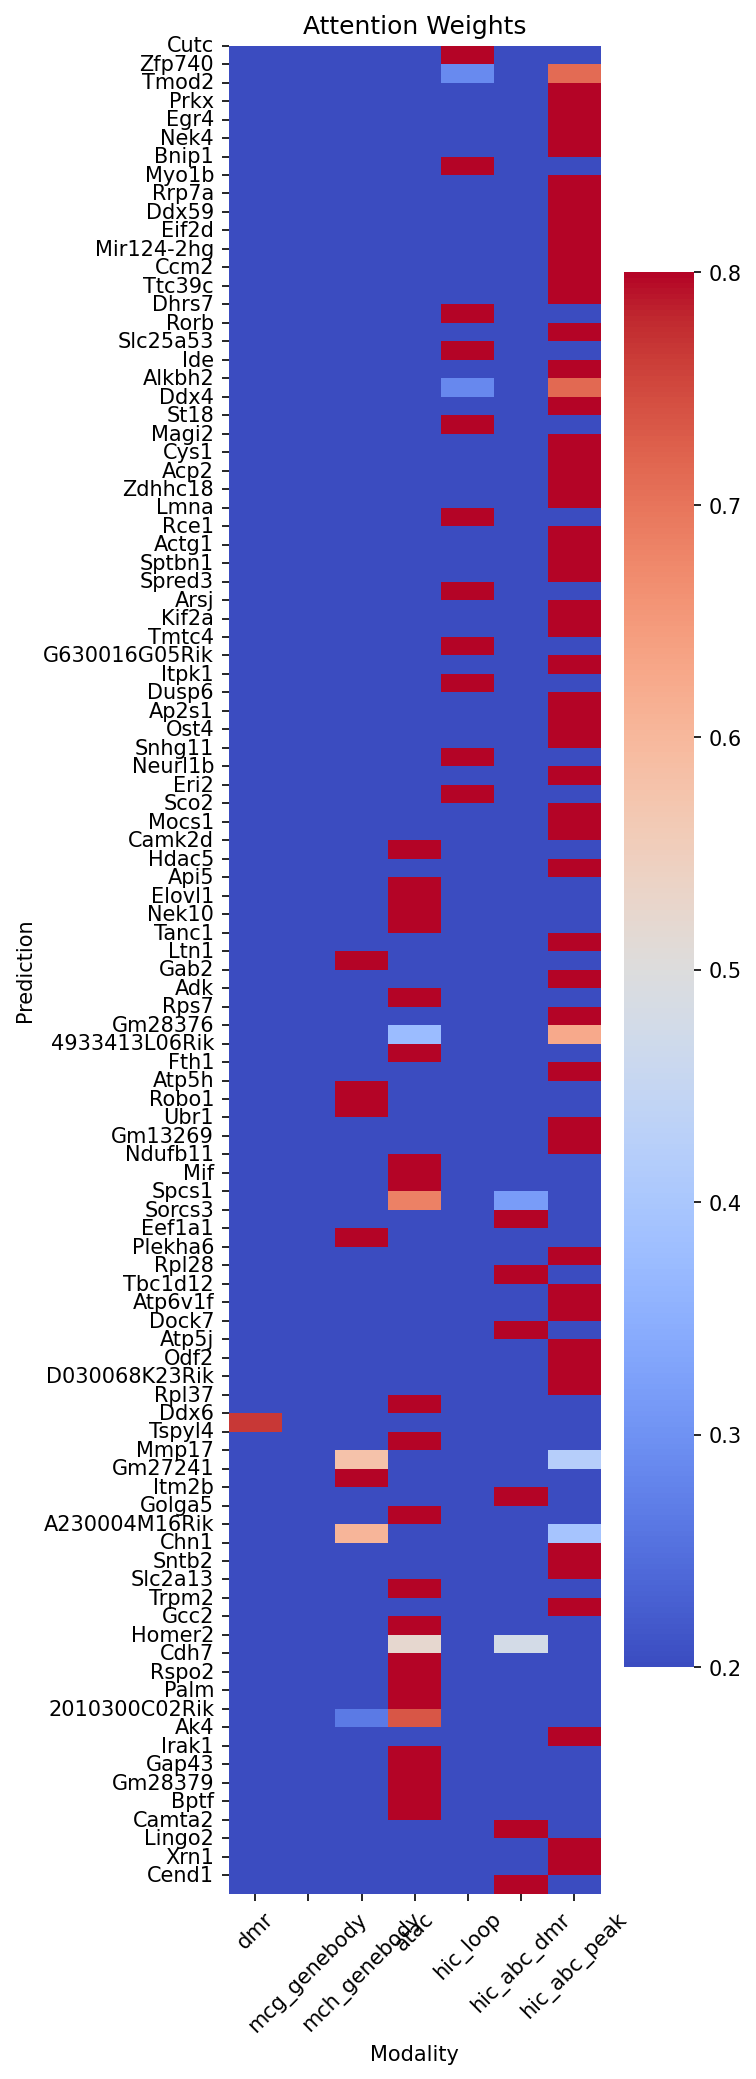

In [6]:
import pandas as pd

if USE_CONCAT_CTS:
    celltype_list, all_gene_list = zip(*[i.split('+') for i in all_gene_list])
else:
    celltype_list = [CT] * len(all_gene_list)
result = pd.DataFrame({
    'cell_type': celltype_list,
    'gene': all_gene_list,
    'DEG': all_labels - 1,
    'pred': all_preds - 1,
    **{
        modality: attn_weights[:, i] for i, modality in enumerate(FEATURE_MODALITIES)
    }
})
output_dir = f'ml_output/{CT}'
os.makedirs(output_dir, exist_ok=True)
result.to_csv(f'{output_dir}/result.csv', index=False)


# Plot the attention weights (each attn_weight is a 4-dim vector)
# We should label each row with the pred and label, and each column with the
# modality name: dmr, atac, hic, genebody
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

# Find all the places where the prediction is correct
print(pd.Series(all_labels).value_counts())
print(pd.Series(all_preds).value_counts())

correct_idx = (all_preds == all_labels)
head = 100
correct_pos = np.where(correct_idx)[0][:head]
fig, ax = plt.subplots(figsize=(4, 16), dpi = 150)
ax = sns.heatmap(attn_weights[correct_pos, :], annot=False, fmt='.2f', cmap='coolwarm', vmin=0.2, vmax=0.8, ax=ax)
ax.set_xlabel('Modality')
ax.set_xticklabels(FEATURE_MODALITIES, rotation=45)
ax.set_ylabel('Prediction')
ax.set_yticks(range(len(correct_pos)))
ax.set_yticklabels([f'{test_gene_list[i]}' for i in correct_pos], rotation=0)
ax.set_title('Attention Weights')
plt.show()

In [11]:
result

,gene,DEG,pred,dmr,mcg_genebody,mch_genebody,atac,hic_loop,hic_abc_dmr,hic_abc_peak
0,Ppm1e,1,2,1.000000e+00,2.813665e-13,1.703935e-11,1.618857e-11,2.039250e-10,2.279140e-09,7.252895e-09
1,Shisa6,1,2,4.522774e-04,8.908551e-01,6.662003e-37,1.051285e-01,3.106516e-14,3.564112e-03,8.683099e-13
2,Kcnh7,1,2,9.328622e-19,5.870820e-27,1.000000e+00,5.167080e-14,2.733925e-28,1.964461e-28,1.321930e-26
3,Auts2,1,2,3.658856e-06,1.081526e-16,1.917611e-32,9.999963e-01,4.385355e-17,1.445816e-11,3.367739e-14
4,Lrrtm4,1,1,1.811754e-14,1.370730e-19,1.972664e-05,9.999803e-01,3.229636e-24,9.525886e-14,2.212106e-22
...,...,...,...,...,...,...,...,...,...,...
361,Apaf1,0,0,4.507363e-34,4.282742e-38,1.000000e+00,3.032091e-16,2.659858e-35,5.195111e-27,7.663599e-34
362,Map2k1,2,1,1.032404e-10,1.486619e-20,6.274807e-10,1.000000e+00,9.065008e-23,1.468892e-11,7.548784e-20
363,Tcerg1,0,2,1.450473e-19,1.755233e-11,9.999816e-01,1.840710e-05,4.570555e-23,1.516748e-13,1.298810e-16
364,Cpne6,0,1,3.753283e-20,2.476924e-02,2.554368e-04,9.749753e-01,3.226145e-25,8.340320e-18,6.234253e-19


In [11]:
for i, (acc, preds, labels, model) in enumerate(accuracies):
    print(f'Fold {i}: {acc:.4f}')

TypeError: cannot unpack non-iterable numpy.float64 object

# plot

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
_labels = [i[0] for i in labels]

result = pd.DataFrame([np.array(_labels) - 1, np.array(preds) - 1 ]).T
result.columns = ['true', 'pred']

<Axes: >

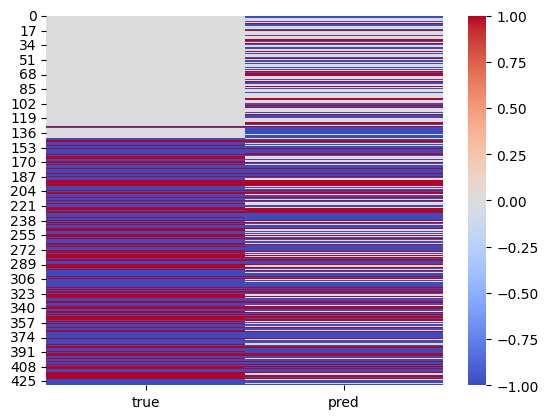

In [10]:
sns.heatmap(result, cmap = 'coolwarm')

In [11]:
result['predict_true'] = result['true'] == result['pred']

In [12]:

toplot= result.groupby('true')['predict_true'].mean()

In [13]:
toplot

true
-1    0.789157
 0    0.525180
 1    0.640000
Name: predict_true, dtype: float64

/var/tmp/ipykernel_44788/1903490480.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['down',  'non-age-deg', 'up',])


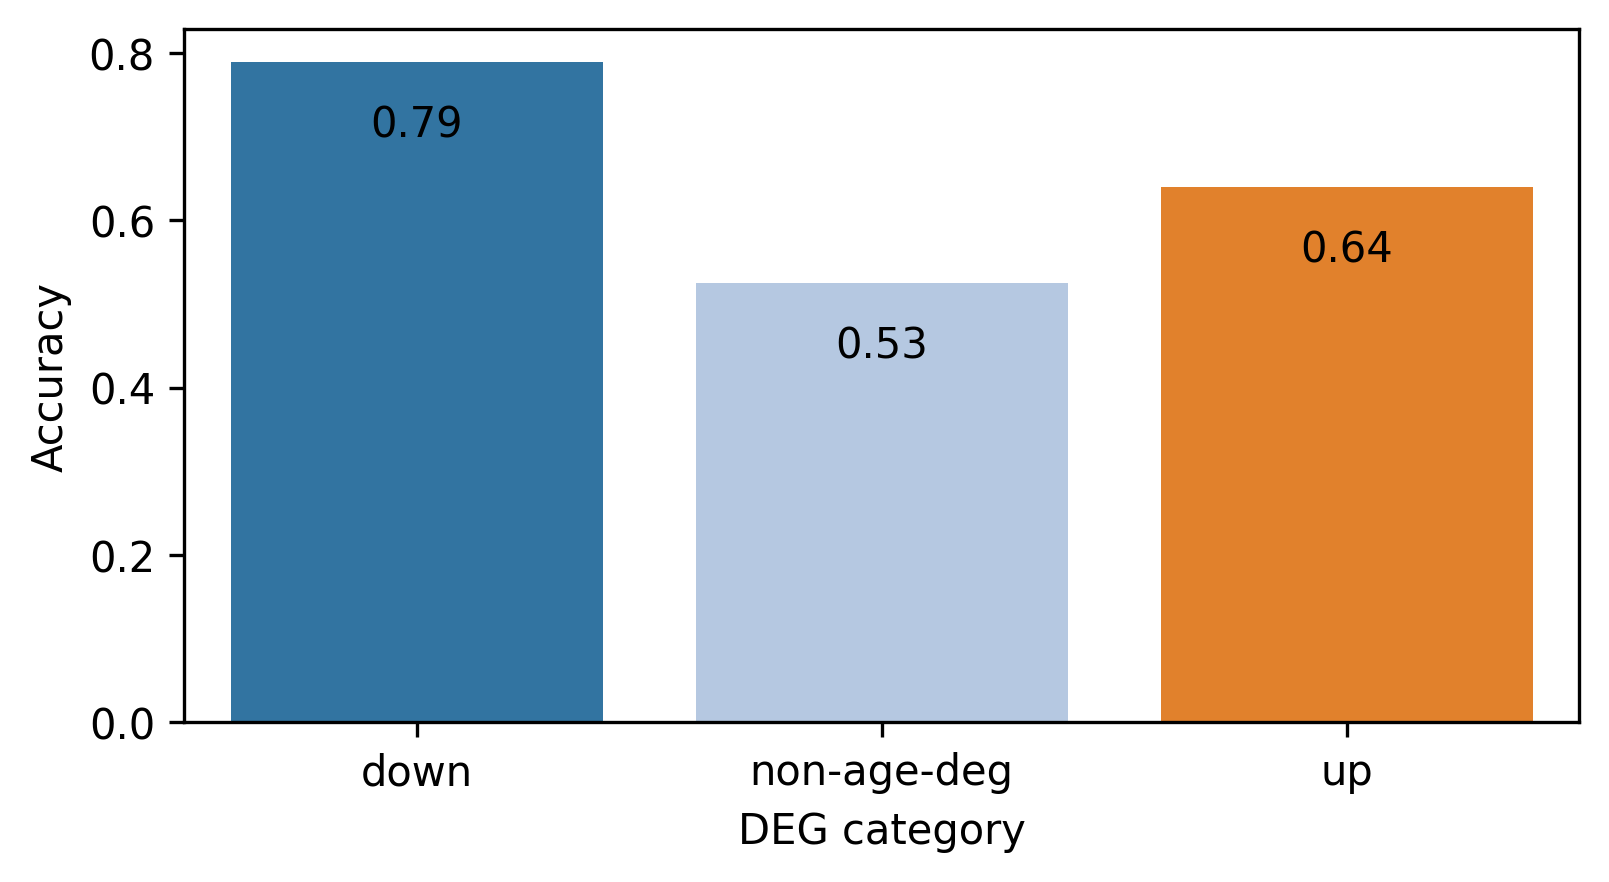

In [15]:
# make a barplot
fig, ax = plt.subplots(figsize=(6, 3), dpi = 300)
sns.barplot(x = toplot.index, ax = ax,palette='tab20',
            hue = toplot.index,y = toplot.values)
# change xticks label as down up and non-age-deg
ax.set_xticklabels(['down',  'non-age-deg', 'up',])
# set xlabel ad DEG category, y as accuracy
ax.set_xlabel('DEG category')
ax.set_ylabel('Accuracy')
#remove the egend
ax.get_legend().remove()
#label accuracy
for i in range(len(toplot)):
    ax.text(i, toplot.values[i]-0.1, round(toplot.values[i], 2), ha = 'center', va = 'bottom')